In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
from sklearn.metrics import mean_squared_error, r2_score


In [6]:


# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

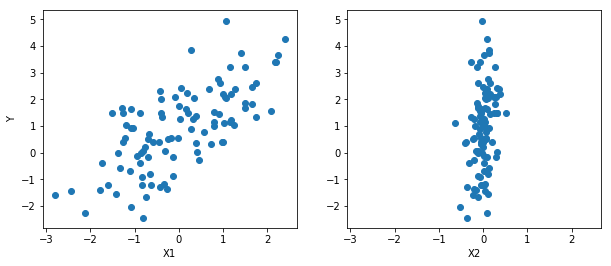

In [7]:
%matplotlib inline

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y'); axes[0].set_xlabel('X1'); axes[1].set_xlabel('X2');

# Declaring the Model

In [8]:

basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pm.Gamma('sigma', alpha = 1., beta =1.) 

    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

# Maximum a posteriori methods

In [9]:

map_estimate = pm.find_MAP(model=basic_model)

map_estimate

logp = -151.2, ||grad|| = 19.257: 100%|██████████| 18/18 [00:00<00:00, 2150.07it/s]  


{'alpha': array(0.90659984),
 'beta': array([0.94848673, 2.60712182]),
 'sigma': array(0.96281842),
 'sigma_log__': array(-0.03789044)}

In [10]:
from scipy import optimize

map_estimate = pm.find_MAP(model=basic_model, fmin=optimize.fmin_powell)

map_estimate

/home/nilavro/irleak/lib/python3.5/site-packages/pymc3/tuning/starting.py:92: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  warnings.warn('In future versions, set the optimization algorithm with a string. '
logp = -290.47:   2%|▏         | 117/5000 [00:00<00:01, 3222.47it/s]

Optimization terminated successfully.
         Current function value: 149.256250
         Iterations: 3
         Function evaluations: 117


{'alpha': array(0.90659967),
 'beta': array([0.94848627, 2.60712189]),
 'sigma': array(0.96282132),
 'sigma_log__': array(-0.03788743)}

# Sampling

In [11]:
from scipy import optimize

with basic_model:
    # draw 500 posterior samples
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/nilavro/irleak/lib/python3.5/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_log__, beta, alpha]
100%|██████████| 1000/1000 [00:01<00:00, 790.84it/s]


In [12]:
with basic_model:

    # obtain starting values via MAP
    start = pm.find_MAP(fmin=optimize.fmin_powell)

    # instantiate sampler
    step = pm.Slice()

    # draw 5000 posterior samples
    trace = pm.sample(5000, step=step, start=start)

/home/nilavro/irleak/lib/python3.5/site-packages/pymc3/tuning/starting.py:92: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  warnings.warn('In future versions, set the optimization algorithm with a string. '
logp = -290.47:   2%|▏         | 117/5000 [00:00<00:01, 2764.06it/s]


Optimization terminated successfully.
         Current function value: 149.256250
         Iterations: 3
         Function evaluations: 117


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [sigma_log__]
>Slice: [beta]
>Slice: [alpha]
100%|██████████| 5500/5500 [00:10<00:00, 532.27it/s]


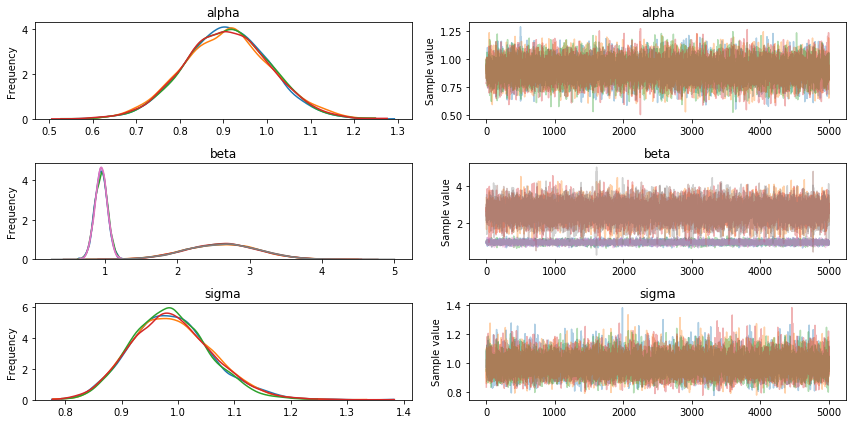

In [13]:
_ = pm.traceplot(trace)


# Sample Dataset 

In [2]:
df = pd.read_csv('/home/nilavro/WorkStation/Codes/R Samples/train.csv')
df.head()

,x,y
0,24,21.549452
1,50,47.464463
2,15,17.218656
3,38,36.586398
4,87,87.288984


In [3]:
y = df['y']
x = df['x']

In [4]:
new_model = pm.Model()

with new_model:

    # Priors for unknown model parameters
     
    beta = pm.Normal('beta', mu=0, sd=1 , shape=2)
    sigma = pm.Gamma('sigma', alpha = 2., beta =1.) 

    # Expected value of outcome
    mu = beta[0] + beta[1] * x[0:500] 

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=y[0:500])

In [ ]:
with new_model:
    advi = pm.ADVI()

In [ ]:
tracker = pm.callbacks.Tracker(
    mean=advi.approx.mean.eval,  # callable that returns mean
    std=advi.approx.std.eval  # callable that returns std
)

In [ ]:
approx = advi.fit(50000, callbacks=[tracker])


In [ ]:
pm.plot_posterior(approx.sample(10000), color='LightSeaGreen');



In [ ]:
plt.scatter( 0.945 * x[500:698] + 0.979 , y[500:698])

In [ ]:
from sklearn import datasets, linear_model


In [ ]:
regr = linear_model.LinearRegression()
regr.fit(x[0:500].reshape(-1,1), y[0:500].reshape(-1,1))


In [ ]:
y_pred = regr.predict(x[500:698].reshape(-1,1))


In [ ]:
plt.scatter(y[500:698] , y_pred)

In [ ]:
approx = advi.fit(50000, callbacks=[tracker])
print('Variance score: %.2f' % r2_score(y[500:698] , y_pred))


In [ ]:
print('Variance score: %.2f' %   r2_score(0.945 * x[500:698] + 0.979 , y[500:698]))

In [ ]:
regr 

In [ ]:
regr.coef_ 